In [51]:
import matplotlib.pyplot as plt
import numpy as np
import meshio
import pymapping
import pygmsh
%matplotlib inline

params = {"axes.titlesize": 14,
          "axes.labelsize": 14,
          "font.size": 14,
          "xtick.labelsize": 14,
          "ytick.labelsize": 14,
          "legend.fontsize": 14,
          "savefig.bbox": "tight",
          "savefig.pad_inches": 0.01}
plt.rcParams.update(params)

# 1-d mapping

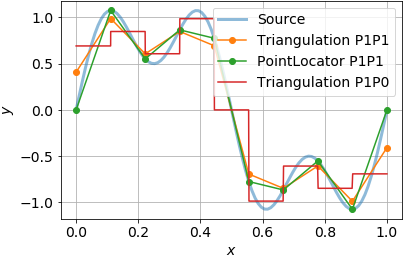

In [52]:
def mesh_unit_interval(N):
    points = np.linspace(0, 1, N)
    cells_line = np.array([(i, i + 1) for i in range(len(points) - 1)], dtype=int)
    cells = {"line": cells_line}
    return meshio.Mesh(points, cells)

def get_P0_visualization(x, y, eps=1e-3):
    assert len(y) == len(x) - 1
    x_ = []
    y_ = []
    for i in range(len(x)):
        if i == 0 or i == len(x) - 1:
            x_.append(x[i])
        else:
            x_.append((1 - eps) * x[i])
            x_.append((1 + eps) * x[i])
    y_ = [val for val in y for _ in range(2)]
    return np.array(x_), np.array(y_)

# Source mesh
mesh_source = mesh_unit_interval(100)
y = np.sin(2 * np.pi * mesh_source.points) + 0.5 * np.sin(6 * np.pi * mesh_source.points)
mesh_source.point_data = {"y": y}
plt.plot(mesh_source.points, y, label="Source", linewidth=3, alpha=0.5)

# Target mesh
mesh_target = mesh_unit_interval(10)

# P1P1 Mapping
remap = pymapping.Remapper(verbose=False)
for intersection_type in ["Triangulation", "PointLocator"]:
    remap.prepare(mesh_source, mesh_target, method="P1P1", intersection_type=intersection_type)
    res = remap.transfer("y")
    plt.plot(mesh_target.points, res.array(), "-o", label=intersection_type + " P1P1")

# P1P0
remap.prepare(mesh_source, mesh_target, method="P1P0", intersection_type="Triangulation")
res = remap.transfer("y")
x_, y_ = get_P0_visualization(mesh_target.points, res.array())
plt.plot(x_, y_, "-", label="Triangulation P1P0")

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid()
plt.legend()
plt.tight_layout()

# 2-d mapping

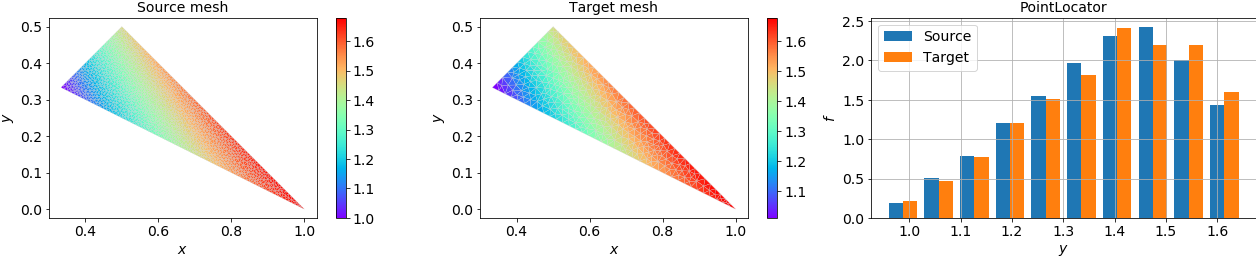

In [57]:
def mesh_TUB(h, recombine=False):
    geom = pygmsh.built_in.Geometry()
    polygon = geom.add_polygon([[1 / 3, 1 / 3, 0], [1, 0, 0], [0.5, 0.5, 0]], lcar=h)
    if recombine:
        geom.add_raw_code("Recombine Surface {%s};" % polygon.surface.id)
    mesh = pygmsh.generate_mesh(geom, dim=2, verbose=False)
    for celltype in ["vertex", "line"]:
        mesh.cells.pop(celltype, None)
    return mesh

plt.figure(figsize=(18, 4))

# Source mesh
plt.subplot(1, 3, 1)
mesh_source = mesh_TUB(0.01)
y = 2 * np.sin(mesh_source.points[:, 0]) + mesh_source.points[:, 1]
mesh_source.point_data = {"y": y}
plt.tripcolor(mesh_source.points[:, 0], mesh_source.points[:, 1], mesh_source.cells["triangle"], y, edgecolors="lightgray", cmap="rainbow")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.gca().set_aspect("equal")
plt.colorbar()
plt.title("Source mesh")
plt.tight_layout()

# Target mesh and P1P1 Mapping
intersection_type = "PointLocator"  # PointLocator, Triangulation
plt.subplot(1, 3, 2)
mesh_target = mesh_TUB(0.02)
remap = pymapping.Remapper(verbose=False)
remap.prepare(mesh_source, mesh_target, method="P1P1", intersection_type=intersection_type)
res = remap.transfer("y")
plt.tripcolor(mesh_target.points[:, 0], mesh_target.points[:, 1], mesh_target.cells["triangle"], res.array(), edgecolors="lightgray", cmap="rainbow")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.gca().set_aspect("equal")
plt.colorbar()
plt.title("Target mesh")
plt.tight_layout()

# Quality accessment
plt.subplot(1, 3, 3)
plt.hist([y, res.array()], density=True, align="left", label=["Source", "Target"])
plt.xlabel("$y$")
plt.ylabel("$f$")
plt.legend()
plt.grid()
plt.title(intersection_type)
plt.tight_layout()